shape of val_set[0] (1000, 784)
shape of val_set[1] (1000, 784)
(784, 10665)
(784, 2000)
(784, 2115)
Best iteration:  99 Validation MSE:  0.01959058912140291


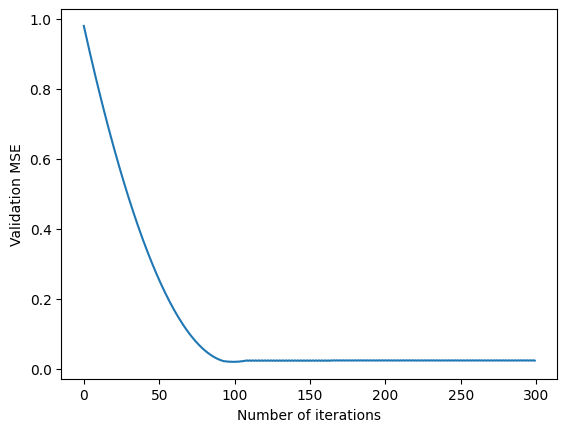

Test MSE:  2.5816219192996757


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class mnistPCA:
    def __init__(self, class_matrix, count):
        self.class_matrix = class_matrix
        self.count = count

        # making the data matrix
        self.X = []
        for i in range(len(self.class_matrix)):
            for j in range(count[i]):
                self.X.append(self.class_matrix[i][j])
        self.X = np.array(self.X)
        self.X = self.X.T


        self.X_mean = np.mean(self.X, axis=1).reshape(784, 1)

        # remove mean from the data
        self.X = self.X - self.X_mean
        print(self.X.shape)

        # use PCA on centralised data
        self.cov_X = np.dot(self.X, self.X.T) / sum(count) - 1

        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.cov_X)
        self.eigen_values = np.real(self.eigen_values)
        self.eigen_vectors = np.real(self.eigen_vectors)

        # sort the eigen values in descending order, and eigen vectors accordingly
        idx = self.eigen_values.argsort()[::-1]
        self.eigen_values = self.eigen_values[idx]
        self.eigen_vectors = self.eigen_vectors[:, idx]

        # making the U matrix
        self.U = []
        for i in range(len(self.eigen_values)):
            self.U.append(self.eigen_vectors[:, :i+1])

    def reduceDim(self, eigen):
        U_p = self.U[eigen - 1]

        # Y = U_p.T * X
        Y = np.dot(U_p.T, self.X)

        Y_label = np.zeros(sum(self.count), dtype=int)

        for i in range(len(self.class_matrix)):
            for j in range(self.count[i]):
                Y_label[sum(self.count[:i]) + j] = i

        return Y, Y_label

# class DecisionTreeRegressor:
#     def __init__(self, max_depth=1):
#         self.max_depth = max_depth
#         self.tree = None

#     def fit(self, X, y):
#         self.tree = self.build_tree(X, y, 0)

#     def build_tree(self, X, y, depth):
#         if depth == self.max_depth or len(np.unique(y)) == 1:
#             return np.mean(y)

#         feature, threshold, X_left, X_right, y_left, y_right = self.best_split(X, y)
#         if feature is None:
#             return np.mean(y)

#         left = self.build_tree(X_left, y_left, depth + 1)
#         right = self.build_tree(X_right, y_right, depth + 1)

#         return [feature, threshold, left, right]

#     def best_split(self, X, y):
#         best_feature = None
#         best_threshold = None
#         best_ssr = float('inf')
#         best_X_left = None
#         best_X_right = None
#         best_y_left = None
#         best_y_right = None

#         for feature in range(X.shape[1]):
#             unique_values = np.unique(X[:, feature])
#             sorted_values = np.sort(unique_values)

#             for i in range(1, len(sorted_values)):
#                 threshold = (sorted_values[i - 1] + sorted_values[i]) / 2.0
#                 y_left = y[X[:, feature] < threshold]
#                 y_right = y[X[:, feature] >= threshold]

#                 ssr = self.ssr(y_left, y_right)
#                 if ssr < best_ssr:
#                     best_feature = feature
#                     best_threshold = threshold
#                     best_ssr = ssr
#                     best_X_left = X[X[:, feature] < threshold]
#                     best_X_right = X[X[:, feature] >= threshold]
#                     best_y_left = y_left
#                     best_y_right = y_right

#         return best_feature, best_threshold, best_X_left, best_X_right, best_y_left, best_y_right

#     def ssr(self, y_left, y_right):
#         mean_left = np.mean(y_left)
#         mean_right = np.mean(y_right)
#         ssr_left = np.sum((y_left - mean_left) ** 2)
#         ssr_right = np.sum((y_right - mean_right) ** 2)
#         total_ssr = ssr_left + ssr_right
#         return total_ssr

class DecisionTreeRegressor:
    def fit(self):
        best_ssr = float('inf')
        best_feature = -1
        best_threshold = -1

        for i in range(self.data.shape[0]):
            d_copy = np.unique(self.data[i])
            means = (d_copy[:-1] + d_copy[1:]) / 2

            for mean in means:
                left_indices = np.where(self.data[i] < mean)
                right_indices = np.where(self.data[i] >= mean)

                left_labels = self.labels[left_indices]
                right_labels = self.labels[right_indices]

                ssr = np.sum((left_labels - np.mean(left_labels)) ** 2) + np.sum((right_labels - np.mean(right_labels)) ** 2)

                if ssr < best_ssr:
                    best_ssr = ssr
                    best_feature = i
                    best_threshold = mean

        # print("Feature: ", best_feature, "Threshold: ", best_threshold, "SSR: ", best_ssr)
        return best_ssr, best_feature, best_threshold

    def __init__(self, data, labels, residuals):
        self.data = data
        self.labels = labels
        self.residuals = residuals

        self.labels = np.sign(self.residuals)

        self.ssr, self.feature, self.threshold = self.fit()

        # print("Feature: ", self.feature, "Threshold: ", self.threshold, "SSR: ", self.ssr)

    def predict(self, data):
        predictions = np.where(data[self.feature] < self.threshold, np.mean(self.labels[self.data[self.feature] < self.threshold]),
                               np.mean(self.labels[self.data[self.feature] >= self.threshold]))

        # print("Mean of predictions: ", np.mean(predictions))
        return predictions


def main():
    # data = np.load('mnist.npz')
    data = np.load(tf.keras.utils.get_file('mnist.npz', 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'))

    train = data['x_train']
    train_label = data['y_train']
    test = data['x_test']
    test_label = data['y_test']

    train = train.reshape(len(train), 784)
    test = test.reshape(len(test), 784)

    # preprocessing the data
    class_matrix = []
    count = np.zeros(2, dtype=int)

    for i in range(2):
        vector = []
        for j in range(len(train)):
            count[i] += 1 if train_label[j] == i else 0
            if train_label[j] == i:
                vector.append(train[j])
        class_matrix.append(vector)

    for i in range(2):
        class_matrix[i] = np.array(class_matrix[i])
    count = np.array(count)

    test_matrix = []
    count_test = np.zeros(2, dtype=int)

    for i in range(2):
        vector = []
        for j in range(len(test)):
            count_test[i] += 1 if test_label[j] == i else 0
            if test_label[j] == i:
                vector.append(test[j])
        test_matrix.append(vector)

    for i in range(2):
        test_matrix[i] = np.array(test_matrix[i])
    count_test = np.array(count_test)

    val_set = []
    for i in range(2):
        vector = []
        for j in range(1000):
            vector.append(class_matrix[i][j])
            class_matrix[i] = np.delete(class_matrix[i], j, axis=0)
        vector = np.array(vector)
        val_set.append(vector)
        count[i] -= 1000

    print("shape of val_set[0]", val_set[0].shape)
    print("shape of val_set[1]", val_set[1].shape)

    test_label = np.zeros(sum(count_test), dtype=int)
    for i in range(2):
        if i == 0:
            for j in range(count_test[i]):
                test_label[j] = -1
        else:
            for j in range(count_test[i]):
                test_label[sum(count_test[:i]) + j] = 1

    pca = mnistPCA(class_matrix, count)
    Y, Y_label = pca.reduceDim(5)

    pca_val = mnistPCA(val_set, np.array([1000, 1000]))
    val_pca, val_label = pca_val.reduceDim(5)

    pca_test = mnistPCA(test_matrix, count_test)
    test_pca, test_label = pca_test.reduceDim(5)

    for i in range(2):
        if i == 0:
            for j in range(count[i]):
                Y_label[j] = -1
        else:
            for j in range(count[i]):
                Y_label[sum(count[:i]) + j] = 1

    for i in range(2):
        if i == 0:
            for j in range(1000):
                val_label[j] = -1
        else:
            for j in range(1000):
                val_label[1000 + j] = 1

    # print(Y.shape)
    # print(Y_label.shape)

    # print(val_pca.shape)
    # print(val_label.shape)

# ------------------------------------------------------------------------------------------------------------------------------------------

    # implement gradient boosting
    init_pred = np.mean(Y_label)
    residuals = Y_label - init_pred

    stumps = []
    mse_arr = []
    residuals_arr = []
    prediction_arr = []

    val_preds = np.mean(val_label)
    val_residuals = val_label - val_preds

    val_mse_arr = []
    val_residuals_arr = []
    val_prediction_arr = []

    learning_rate = 0.01
    for i in range(300):
        stump = DecisionTreeRegressor(Y, Y_label, residuals)
        stumps.append(stump)

        predictions = stump.predict(Y)
        residuals -= learning_rate * predictions

        prediction_arr.append(np.mean(predictions))

        mse = np.mean(residuals ** 2)
        mse_arr.append(mse)
        residuals_arr.append(residuals)

        # print(i, end=" ")
        # print("MSE: ", mse, end = " ")
        # print("Mean of predictions: ", np.mean(predictions))

        # Vaidation

        val_predictions = stumps[i].predict(val_pca)
        val_residuals -= learning_rate * val_predictions

        val_prediction_arr.append(np.mean(val_predictions))

        val_mse = np.mean(val_residuals ** 2)
        val_mse_arr.append(val_mse)
        val_residuals_arr.append(val_residuals)

        best_val_mse = min(val_mse_arr)
        if val_mse == best_val_mse:
            best_val_iter = i

        # print(i, end=" ")
        # print("Validation MSE: ", val_mse, end = " ")
        # print("Mean of predictions: ", np.mean(val_predictions))

    print("Best iteration: ", best_val_iter, end = " ")
    print("Validation MSE: ", best_val_mse)

    plt.plot(val_mse_arr)
    plt.xlabel('Number of iterations')
    plt.ylabel('Validation MSE')
    plt.show()

    # Using tree that gives lowest MSE to evaluate test set
    test_predictions = stumps[best_val_iter].predict(test_pca)
    test_residuals = test_label - test_predictions

    test_mse = np.mean(test_residuals ** 2)
    print("Test MSE: ", test_mse)


if __name__ == "__main__":
    main()
